Epoch[1/25], G Loss: nan, D Loss: nan


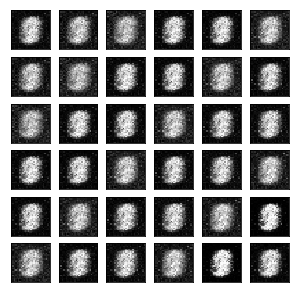

Epoch[2/25], G Loss: -0.0558, D Loss: -0.1518


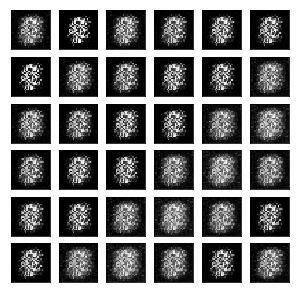

Epoch[3/25], G Loss: -0.0757, D Loss: -0.1444


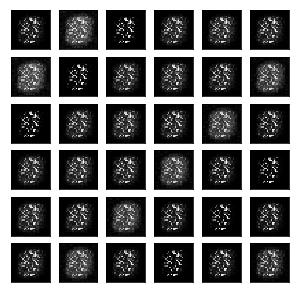

Epoch[4/25], G Loss: -0.0889, D Loss: -0.1139


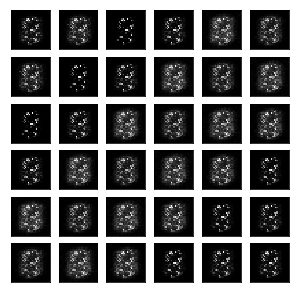

Epoch[5/25], G Loss: -0.0597, D Loss: -0.1341


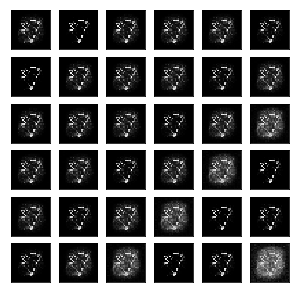

Epoch[6/25], G Loss: -0.0424, D Loss: -0.2702


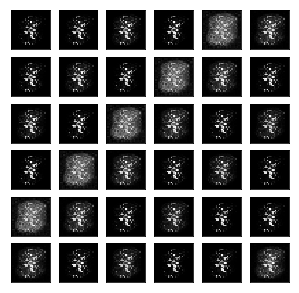

Epoch[7/25], G Loss: -0.0285, D Loss: -0.3022


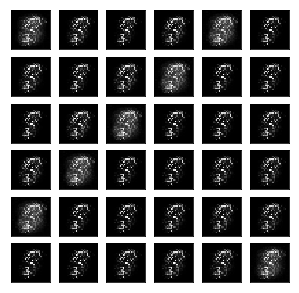

Epoch[8/25], G Loss: -0.0201, D Loss: -0.3220


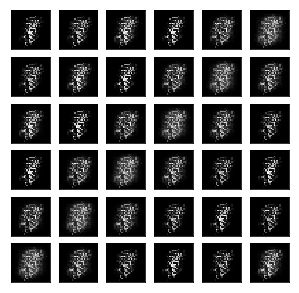

Epoch[9/25], G Loss: nan, D Loss: nan


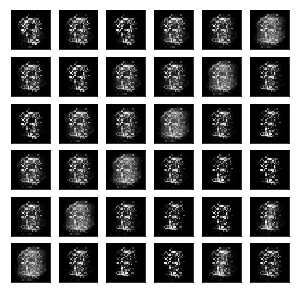

Epoch[10/25], G Loss: -0.0212, D Loss: -0.2851


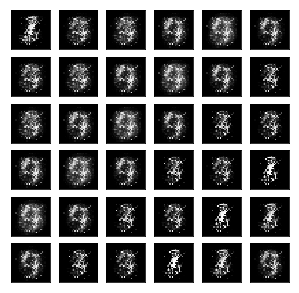

Epoch[11/25], G Loss: nan, D Loss: nan


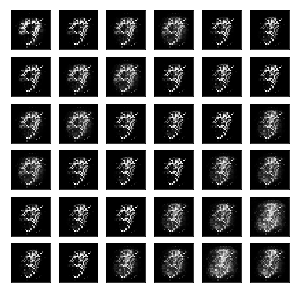

Epoch[12/25], G Loss: nan, D Loss: nan


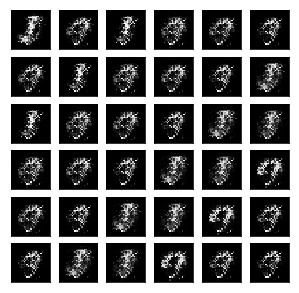

Epoch[13/25], G Loss: nan, D Loss: nan


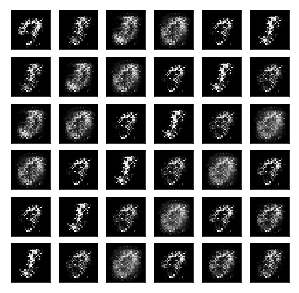

Epoch[14/25], G Loss: nan, D Loss: nan


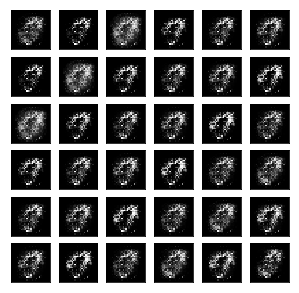

Epoch[15/25], G Loss: nan, D Loss: nan


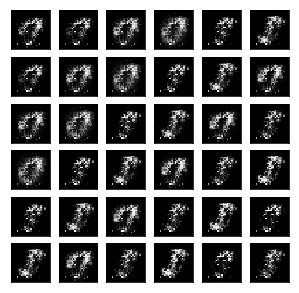

Epoch[16/25], G Loss: -0.0069, D Loss: -0.3694


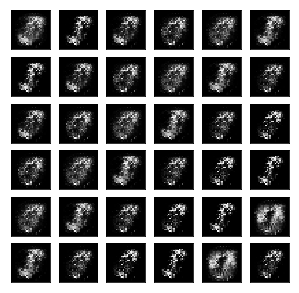

Epoch[17/25], G Loss: -0.0040, D Loss: -0.3737


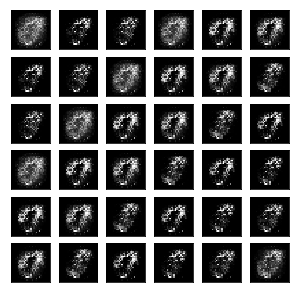

Epoch[18/25], G Loss: -0.0023, D Loss: -0.3761


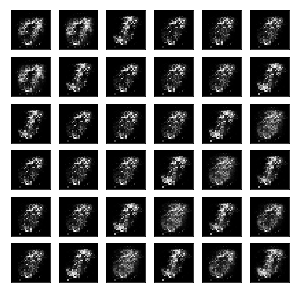

Epoch[19/25], G Loss: -0.0015, D Loss: -0.3773


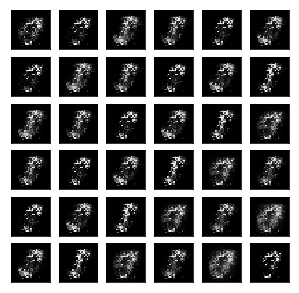

Epoch[20/25], G Loss: -0.0015, D Loss: -0.3776


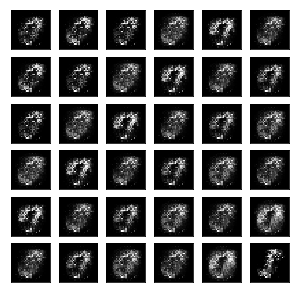

Epoch[21/25], G Loss: -0.0012, D Loss: -0.3779


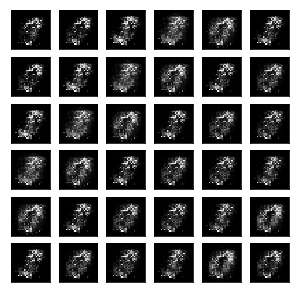

Epoch[22/25], G Loss: -0.0010, D Loss: -0.3782


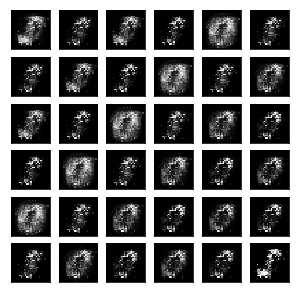

Epoch[23/25], G Loss: -0.0008, D Loss: -0.3786


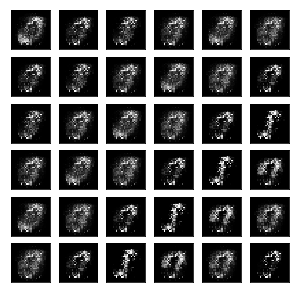

Epoch[24/25], G Loss: -0.0006, D Loss: -0.3786


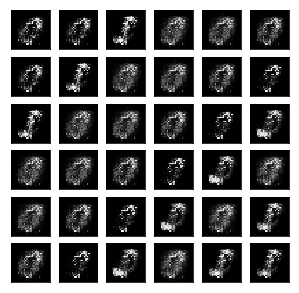

Epoch[25/25], G Loss: -0.0008, D Loss: -0.3781


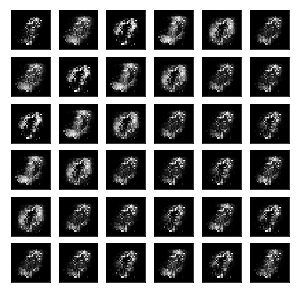

In [40]:
""" (f-GAN)

The authors empirically demonstrate that when the generative model is 
misspecified and does not contain the true distribution, the divergence 
function used for estimation has a strong influence on which model is 
learned. To address this issue, they theoretically show that the 
generative-adversarial approach is a special case of an existing, more 
general variational divergence estimation approach and that any 
f-divergence can be used for training generative neural samplers (which
are defined as models that take a random input vector and produce a sample
from a probability distribution defined by the network weights). They
then empirically show the effect of using different training
divergences on a trained model's average log likelihood of sampled data.

They test (forward) Kullback-Leibler, reverse Kullback-Leibler, Pearson 
chi-squared, Neyman chi-squared, squared Hellinger, Jensen-Shannon,
and Jeffrey divergences.

TODO: fix Neyman

We exclude Jeffrey due to poor performance and nontrivial implementation.
(see scipy.special.lambertw otherwise)

https://arxiv.org/pdf/1606.00709.pdf
"""

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

def to_var(x):
    """ Make a tensor cuda-erized and requires gradient """
    return to_cuda(x).requires_grad_()


def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = torch.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Discriminator. Input is an image (real or generated), output is P(generated).
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = torch.sigmoid(self.discriminate(activated))
        return discrimination


class fGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.__dict__.update(locals())

        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)


class Divergence:
    """ Compute G and D loss using an f-divergence metric.
    Implementations based on Table 6 (Appendix C) of the arxiv paper. 
    """
    def __init__(self, method):
        self.method = method.lower().strip()
        assert self.method in ['total_vartiation', 
                               'forward_kl',
                               'reverse_kl',
                               'hellinger',
                               'pearson',
#                                'neyman', #TODO: fix neyman
                               'jensen_shannon'], \
            'Invalid divergence.'

    def D_loss(self, DX_score, DG_score):
        """ Compute batch loss for discriminator using f-divergence metric """
        
        if self.method == 'total_vartiation':
            return -(torch.mean(0.5*torch.tanh(DX_score)) - torch.mean(0.5*torch.tanh(DG_score)))
        
        elif self.method == 'forward_kl':
            return -(torch.mean(DX_score) - torch.mean(torch.exp(DG_score-1)))
        
        elif self.method == 'reverse_kl':
            return -(torch.mean(-torch.exp(DX_score)) - torch.mean(-1-DG_score))
        
        elif self.method == 'hellinger':
            return -(torch.mean(1-torch.exp(DX_score)) - torch.mean((1-torch.exp(DG_score))/(torch.exp(DG_score))))
        
        elif self.method == 'pearson':
            return -(torch.mean(DX_score) - torch.mean(0.25*DG_score**2 + DG_score))
        
        elif self.method == 'neyman':
            return -(torch.mean(1-torch.exp(DX_score)) - torch.mean(2 - 2*(1-DG_score)**0.50))
        
        elif self.method == 'jensen_shannon':
            return -(torch.mean(torch.log(torch.tensor(2.))-torch.log(1+torch.exp(-DX_score+1e-8))) - torch.mean(-torch.log(torch.tensor(2.)-torch.exp(DG_score)+1e-8)))
        
    def G_loss(self, DG_score):
        """ Compute batch loss for generator using f-divergence metric """

        if self.method == 'total_vartiation':
            return -torch.mean(0.5*torch.tanh(DG_score))
        
        elif self.method == 'forward_kl':
            return -torch.mean(torch.exp(DG_score-1))

        elif self.method == 'reverse_kl':
            return -torch.mean(-1-DG_score)
        
        elif self.method == 'hellinger':
            return -torch.mean((1-torch.exp(DG_score))/(torch.exp(DG_score)))
        
        elif self.method == 'pearson':
            return -torch.mean(0.25*DG_score**2 + DG_score) 
        
        elif self.method == 'neyman':
            return -torch.mean(2 - 2*(1-DG_score)**0.50)
        
        elif self.method == 'jensen_shannon':
            return -torch.mean(-torch.log(torch.tensor(2.)-torch.exp(DG_score)+1e-8))


class fGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
                
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz

    def train(self, num_epochs, method='forward_kl', G_lr=1e-4, D_lr=1e-4, D_steps=1):
        """ Train a vanilla GAN using the non-saturating gradients loss for the generator. 
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            method: str, divergence metric to optimize (default 'forward_kl')
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
        """
        # Initialize loss
        self.loss_fnc = Divergence(method)
        
        # Initialize optimizers
        G_optimizer = optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to learn to discriminate between real and generated images
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # So that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to generate images that fool the discriminator
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()

    def train_D(self, images):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: non-saturing loss for discriminator, 
        """    
        # Generate labels (ones indicate real images, zeros indicate generated)
        X_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        G_labels = to_cuda(torch.zeros(images.shape[0], 1)) 
        
        # Classify the real batch images, get the loss for these 
        DX_score = self.model.D(images)
        
        # Sample noise z, generate output G(z)
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = self.model.G(noise)
        
        # Classify the fake batch images, get the loss for these using sigmoid cross entropy
        DG_score = self.model.D(G_output)
        
        # Compute f-divergence loss
        D_loss = self.loss_fnc.D_loss(DX_score, DG_score)
                
        return D_loss

    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: non-saturating loss for how well G(z) fools D, 
        """        
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        
        # Get noise (denoted z), classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute f-divergence loss
        G_loss = self.loss_fnc.G_loss(DG_score)
        
        return G_loss

    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))

    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images

    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = fGAN(image_size=784, 
             hidden_dim=256, 
             z_dim=128)

trainer = fGANTrainer(model=model, 
                      train_iter=train_iter, 
                      val_iter=val_iter, 
                      test_iter=test_iter,
                      viz=True)

#                                'neyman',
#                                'jensen_shannon'

trainer.train(num_epochs=25, 
              method='jensen_shannon',
              G_lr=1e-4, 
              D_lr=1e-4, 
              D_steps=1)